In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
import os
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
TRAIN_DIR = "./Data1"
IMG_SIZE = 128
SEED = 1000
BATCH_SIZE = 8

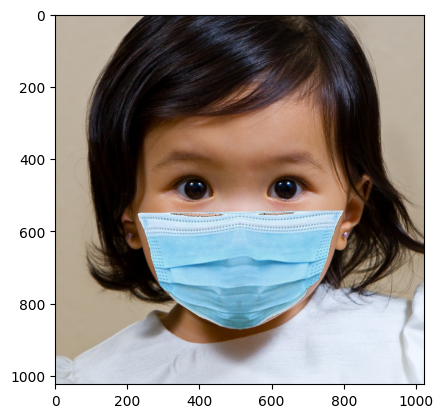

(1024, 1024, 3)


In [3]:
img = cv2.imread('./Data1/Train/Mask/00003_Mask.jpg')
#Converts from BGR to RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.show()
print(img.shape)

In [4]:
train_gen = ImageDataGenerator(
    rotation_range = 20,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True,
    validation_split = 0.2,
    preprocessing_function = tf.keras.applications.vgg16.preprocess_input
)

test_gen = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.vgg16.preprocess_input
)

In [5]:
train_batch = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'sparse', 
    subset = 'training',
    seed = SEED
)
valid_batch = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'sparse',
    subset = 'validation',
    seed = SEED
)

Found 1823 images belonging to 2 classes.
Found 455 images belonging to 2 classes.


In [6]:
img_shape = (IMG_SIZE, IMG_SIZE) + (3,)
base_model = tf.keras.applications.VGG16(input_shape=img_shape, include_top=False,  weights='imagenet')
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [7]:
inputs = tf.keras.Input(shape=(IMG_SIZE,IMG_SIZE, 3))
x = base_model(inputs, training=True)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
output = tf.keras.layers.Dense(2, activation='softmax')(x)

model = tf.keras.Model(inputs, output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                             

In [8]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
    loss= tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

In [9]:
# Training of base_model = False
h = model.fit(
    train_batch,
    steps_per_epoch = 300 // BATCH_SIZE,
    validation_data=valid_batch,
    validation_steps= 100  // BATCH_SIZE,
)

37/37 [==============================] - 82s 2s/step - loss: 7.8773 - accuracy: 0.7297 - val_loss: 0.4207 - val_accuracy: 0.8542


In [11]:
model.save('./face_mask_model.h5')